In [2]:
import pandas as pd
import numpy as np
import tabula
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.simplefilter('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
pd.options.display.float_format = "{:,.1f}".format

In [3]:
prov16 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv')
prov17 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2017.csv')
prov18 = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\Medicare_Provider_Charge_Inpatient_DRGALL_FY2018.csv')
drg_cat= pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\drg_category.csv')
inpcl  = pd.read_csv(r'C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\exl\\2008_BSA_Inpatient_Claims_PUF.csv')

### Data Preparation - Provider Data

In [4]:
# Concatenating similar columns from each dataset to check for data & heading discrepancies

prov16['Year'] = '2016'
prov17['Year'] = '2017'
prov18['Year'] = '2018'
test=pd.DataFrame()
for colnum in range(prov16.shape[1]):
    test = pd.concat([test,prov16.iloc[:,colnum].head(),prov17.iloc[:,colnum].head(),prov18.iloc[:,colnum].head()],axis=1)
test

# Flagged Heading discrepancies in 'prov18' data, also 'prov16' data is not float type unlike other datasets due to $ signs

,DRG Definition,DRG Definition,DRG_DESC,Provider Id,Provider Id,PROVIDER_ID,Provider Name,Provider Name,FACILITY_NAME,Provider Street Address,Provider Street Address,FACILITY_STREET_ADDRESS,Provider City,Provider City,FACILITY_CITY,Provider State,Provider State,STATE_DESC,Provider Zip Code,Provider Zip Code,FACILITY_ZIP_CODE,Hospital Referral Region (HRR) Description,Hospital Referral Region (HRR) Description,HRR_DESC,Total Discharges,Total Discharges,DISCHARGE_COUNT_SUM,Average Covered Charges,Average Covered Charges,MEAN_COVERED_CHARGES,Average Total Payments,Average Total Payments,MEAN_MEDICARE_PAYMENTS,Average Medicare Payments,Average Medicare Payments,MEAN_MEDICARE_REIMBURSEMENT,Year,Year,Year
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE CNS PDX W MCC OR CHEMOTHE,"003 - ""ECMO OR TRACH W MV >96 HRS OR PDX EXC FACE, MOUTH & NECK W MAJ O.R.",10033,10001,10001,UNIVERSITY OF ALABAMA HOSPITAL,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,619 SOUTH 19TH STREET,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,BIRMINGHAM,DOTHAN,DOTHAN,AL,AL,AL,35233,36301,36301,AL - Birmingham,AL - Dothan,AL - Dothan,13,28,13,"$1,016,806.46","117,117.8","368,434.0","$296,937.00","25,823.7","81,540.9","$150,139.69","24,057.4","80,434.9",2016,2017,2018
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W MCC,023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACUTE COMPLEX CNS PDX W MCC OR,30103,10001,10001,MAYO CLINIC HOSPITAL,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,5777 EAST MAYO BOULEVARD,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,PHOENIX,DOTHAN,DOTHAN,AZ,AL,AL,85054,36301,36301,AZ - Phoenix,AL - Dothan,AL - Dothan,26,32,33,"$443,387.54","98,357.6","148,677.1","$215,059.54","20,688.3","29,061.5","$163,889.31","19,791.4","27,996.6",2016,2017,2018
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,027 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W/O CC/MCC,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDURES W MCC,40114,10001,10001,BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,"9601 INTERSTATE 630, EXIT 7",1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,LITTLE ROCK,DOTHAN,DOTHAN,AR,AL,AL,72205,36301,36301,AR - Little Rock,AL - Dothan,AL - Dothan,33,11,26,"$711,472.00","69,153.5","118,718.3","$180,315.55","11,811.2","22,441.8","$145,192.61","8,194.4","19,591.8",2016,2017,2018
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,037 - EXTRACRANIAL PROCEDURES W MCC,038 - EXTRACRANIAL PROCEDURES W CC,50025,10001,10001,UC SAN DIEGO HEALTH HILLCREST - HILLCREST MED CTR,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,200 WEST ARBOR DRIVE,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,SAN DIEGO,DOTHAN,DOTHAN,CA,AL,AL,92103,36301,36301,CA - San Diego,AL - Dothan,AL - Dothan,17,12,11,"$796,343.82","100,427.3","74,449.2","$299,244.41","19,134.0","9,546.0","$270,131.59","18,154.0","7,561.8",2016,2017,2018
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,038 - EXTRACRANIAL PROCEDURES W CC,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50100,10001,10001,SHARP MEMORIAL HOSPITAL,SOUTHEAST ALABAMA MEDICAL CENTER,SOUTHEAST ALABAMA MEDICAL CENTER,7901 FROST ST,1108 ROSS CLARK CIRCLE,1108 ROSS CLARK CIRCLE,SAN DIEGO,DOTHAN,DOTHAN,CA,AL,AL,92123,36301,36301,CA - San Diego,AL - Dothan,AL - Dothan,13,17,64,"$1,434,651.46","58,199.5","46,627.8","$239,537.46","8,519.5","6,468.3","$215,205.00","6,714.9","5,073.3",2016,2017,2018


In [5]:
# Replace the $ signs & convert all the object columns to float datatype 

for col in prov16[['Average Covered Charges', 'Average Total Payments','Average Medicare Payments']]:
    prov16[col] = prov16[col].apply(lambda x: x.replace(',','').replace('$',''))
prov16 = prov16.astype({'Average Covered Charges':'float','Average Total Payments':'float','Average Medicare Payments':'float'})
prov16['Total Discharges']=prov16['Total Discharges'].apply(lambda x: str(x))
prov16['Total Discharges'] = prov16['Total Discharges'].apply(lambda x: x.replace(',','')).astype('int64')
prov16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197283 entries, 0 to 197282
Data columns (total 13 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   DRG Definition                              197283 non-null  object 
 1   Provider Id                                 197283 non-null  int64  
 2   Provider Name                               197283 non-null  object 
 3   Provider Street Address                     197283 non-null  object 
 4   Provider City                               197283 non-null  object 
 5   Provider State                              197283 non-null  object 
 6   Provider Zip Code                           197283 non-null  int64  
 7   Hospital Referral Region (HRR) Description  197283 non-null  object 
 8   Total Discharges                            197283 non-null  int64  
 9   Average Covered Charges                     197283 non-null  float64
 

In [6]:
# Repairing 'prov18' data headings & make them uniform across all datasets to ensure error free concatenation
prov18.columns = prov16.columns
prov = pd.concat([prov16,prov17,prov18])

# Extracting DRG codes from DRG Definitions in a separate column

prov['MS_DRG_CD']= prov['DRG Definition'].str[:3]
prov['MS_DRG_CD']=prov['MS_DRG_CD'].astype('int64')
prov = prov.astype({'Provider Id' : 'object', 'Provider Zip Code':'object'})

print(prov.shape,'\n')
print(prov.dtypes)

(586611, 14) 

DRG Definition                                 object
Provider Id                                    object
Provider Name                                  object
Provider Street Address                        object
Provider City                                  object
Provider State                                 object
Provider Zip Code                              object
Hospital Referral Region (HRR) Description     object
Total Discharges                                int64
Average Covered Charges                       float64
Average Total Payments                        float64
Average Medicare Payments                     float64
Year                                           object
MS_DRG_CD                                       int64
dtype: object


### Exploratory Data Analysis - Provider Data

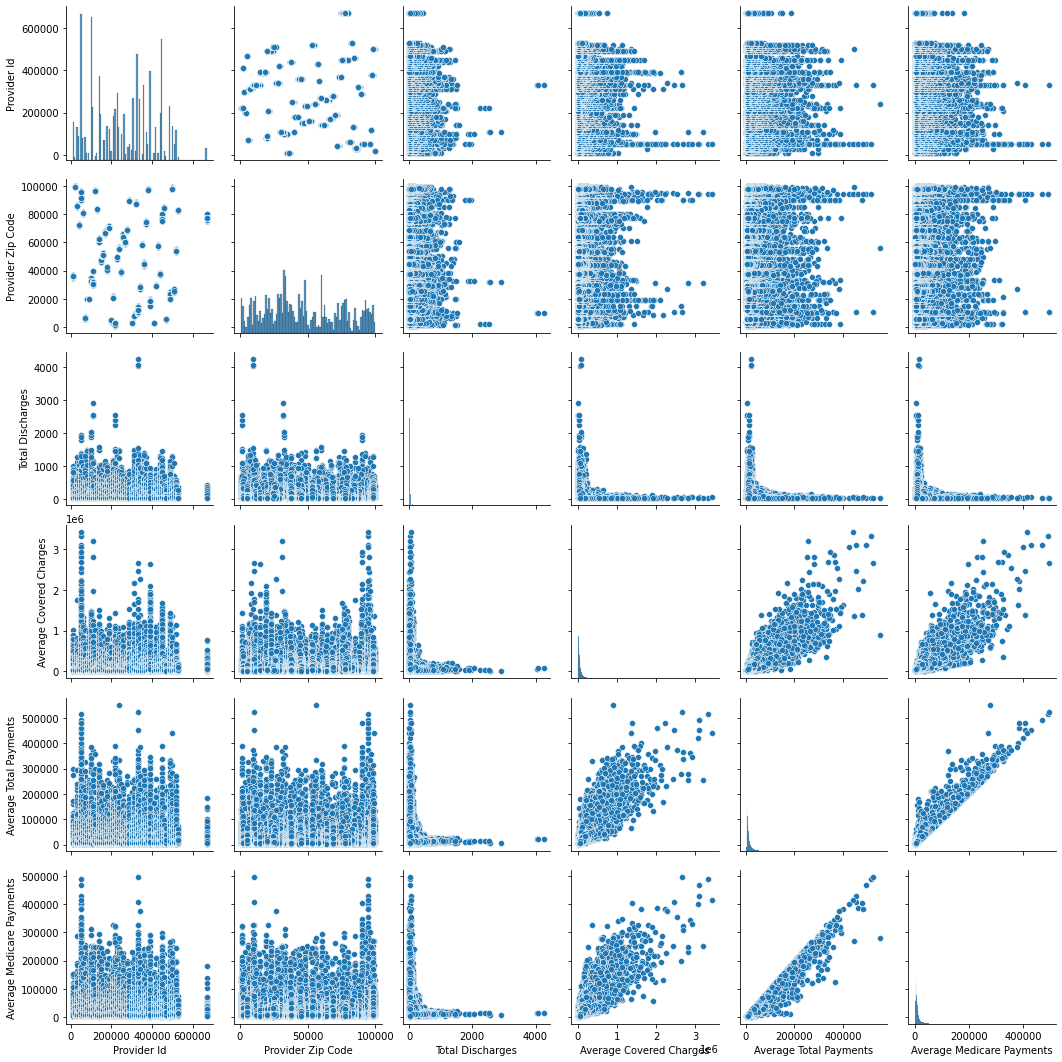

In [7]:
sns.pairplot(prov[prov16.columns])
plt.show()

In [10]:
# Means are consistently more than the Median, suggesting highly Right skewed Data

prov.describe(include='all')

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Year,MS_DRG_CD
count,586611,"586,611.0",586611,586611,586611,586611,"586,611.0",586611,"586,611.0","586,611.0","586,611.0","586,611.0",586611,"586,611.0"
unique,662,"3,260.0",3470,3352,1941,51,"2,986.0",306,nan,nan,nan,nan,3,nan
top,871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV >96 HOURS W MCC,"100,007.0",GOOD SAMARITAN HOSPITAL,601 E ROLLINS ST,BALTIMORE,CA,"77,030.0",MA - Boston,nan,nan,nan,nan,2016,nan
freq,8506,"1,179.0",1543,1179,4915,45500,"1,821.0",12212,nan,nan,nan,nan,197283,nan
mean,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,37.4,"61,339.2","14,076.7","11,900.1",NaN,414.1
std,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,55.9,"73,608.5","14,862.0","13,210.0",NaN,248.3
min,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,11.0,"1,520.8","2,365.8",0.0,NaN,1.0
25%,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,14.0,"24,123.2","6,583.1","5,203.4",NaN,216.0
50%,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,22.0,"40,248.4","9,730.7","8,105.6",NaN,371.0
75%,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,39.0,"71,074.8","15,640.7","13,199.5",NaN,605.0


In [11]:
#Extracting additional data from a PDF containing info on DRG Codes

tables = tabula.read_pdf("C:\\Users\\Ashis\\Dropbox\\My PC (LAPTOP-05U11M48)\\Desktop\\176744_2008_BSA_Inpatient_Claims_PUF_DataDic_CB.pdf",pages=[2,3,4,5,6,7,8,9,10,11,12],multiple_tables=True)

In [12]:
#Extracting additional data from a PDF containing info on DRG Codes

dict0 = {'Variable\rValue':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
          'Included MS-\rDRG codes':['001; 002','003','004','005; 006','007','008','009','010','011; 012; 013','020; 021; 022','023; 024','025; 026; 027','028; 029; 030','031; 032; 033','034; 035; 036','037; 038; 039','040; 041; 042'],
         'Formatted Value':['Heart transplant or implant of heart assist system','ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.','Trach w MV 96+ hrs or PDX exc face, mouth & neck w/o maj O.R.','Liver transplant','Lung transplant','Simultaneous pancreas/kidney transplant','Bone marrow transplant','Pancreas transplant','Tracheostomy for face,mouth & neck diagnoses','Intracranial vascular procedures w PDX hemorrhage','Cranio w major dev impl/acute complex CNS PDX','Craniotomy & endovascular intracranial procedures','Spinal procedures','Ventricular shunt procedures','Carotid artery stent procedure','Extracranial procedures','Periph/cranial nerve & other nerv syst']}
table0 = pd.DataFrame(dict0)

In [13]:
#Extracting additional data from a PDF from CMS.gov website containing info on DRG Codes

table = table0
for i in range(1,len(tables)):
    table = pd.concat([table,tables[i].iloc[:,0:3]])
    
table = table.iloc[:,0:3]

table = table.dropna(how='all',axis=0).reset_index(drop=True)
table['Included MS-\rDRG codes'] = table['Included MS-\rDRG codes'].str.replace(';',',')
table['Included MS-\rDRG codes']=table['Included MS-\rDRG codes'].str.split(',')
table = table.explode('Included MS-\rDRG codes').reset_index(drop=True)
table['Included MS-\rDRG codes'] = table['Included MS-\rDRG codes'].astype('int')
table.columns = ['IP_CLM_BASE_DRG_CD','MS_DRG_CD','BASE_COND']
table[table.IP_CLM_BASE_DRG_CD.isnull()]
table = table.drop([352,571])
table['IP_CLM_BASE_DRG_CD'] = table['IP_CLM_BASE_DRG_CD'].astype('int')
table.isna().sum()
table.head(10)

,IP_CLM_BASE_DRG_CD,MS_DRG_CD,BASE_COND
0,1,1,Heart transplant or implant of heart assist system
1,1,2,Heart transplant or implant of heart assist system
2,2,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R."
3,3,4,"Trach w MV 96+ hrs or PDX exc face, mouth & neck w/o maj O.R."
4,4,5,Liver transplant
5,4,6,Liver transplant
6,5,7,Lung transplant
7,6,8,Simultaneous pancreas/kidney transplant
8,7,9,Bone marrow transplant
9,8,10,Pancreas transplant


In [14]:
#Merging additional data from the DRG PDF into the original Provider Dataset

prov = pd.merge(prov,table,how='left',on='MS_DRG_CD')
prov.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Year,MS_DRG_CD,IP_CLM_BASE_DRG_CD,BASE_COND
0,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,13,"1,016,806.5","296,937.0","150,139.7",2016,1,1.0,Heart transplant or implant of heart assist system
1,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,30103,MAYO CLINIC HOSPITAL,5777 EAST MAYO BOULEVARD,PHOENIX,AZ,85054,AZ - Phoenix,26,"443,387.5","215,059.5","163,889.3",2016,1,1.0,Heart transplant or implant of heart assist system
2,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,40114,BAPTIST HEALTH MEDICAL CENTER-LITTLE ROCK,"9601 INTERSTATE 630, EXIT 7",LITTLE ROCK,AR,72205,AR - Little Rock,33,"711,472.0","180,315.5","145,192.6",2016,1,1.0,Heart transplant or implant of heart assist system
3,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,50025,UC SAN DIEGO HEALTH HILLCREST - HILLCREST MED CTR,200 WEST ARBOR DRIVE,SAN DIEGO,CA,92103,CA - San Diego,17,"796,343.8","299,244.4","270,131.6",2016,1,1.0,Heart transplant or implant of heart assist system
4,001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,50100,SHARP MEMORIAL HOSPITAL,7901 FROST ST,SAN DIEGO,CA,92123,CA - San Diego,13,"1,434,651.5","239,537.5","215,205.0",2016,1,1.0,Heart transplant or implant of heart assist system


In [15]:
# Extracting additional info available on DRG codes from Wikipedia

DRG_Class = pd.DataFrame()
for i in range(drg_cat.shape[0]):
    #print(i)
    diff = drg_cat.iloc[i,3] - drg_cat.iloc[i,2]
    df = pd.DataFrame()
    for j in range(diff+1):
        #print(j)
        df = df.append(pd.DataFrame(drg_cat.iloc[i,:]).T)
    df.index = range(drg_cat.iloc[i,2],drg_cat.iloc[i,3]+1)
    DRG_Class = DRG_Class.append(df)
DRG_Class=DRG_Class.reset_index()
DRG_Class.drop(['DRG_low','DRG_high'],axis=1,inplace=True)
DRG_Class.columns=['MS_DRG_CD','MDC','Condition_Family']
DRG_Class.head()

,MS_DRG_CD,MDC,Condition_Family
0,1,0.0,Pre-MDC
1,2,0.0,Pre-MDC
2,3,0.0,Pre-MDC
3,4,0.0,Pre-MDC
4,5,0.0,Pre-MDC


In [16]:
# Merging Additional Info from Wikipedia into our original Provider data

prov = pd.merge(prov,DRG_Class, how='left',on='MS_DRG_CD')

# Constructing Additional Variables in Provider Data

prov['Covered_Charges_total'] = prov['Average Covered Charges']*prov['Total Discharges']
prov['Payments_total'] = prov['Average Total Payments']*prov['Total Discharges']
prov['Medicare_Payments_total'] = prov['Average Medicare Payments']*prov['Total Discharges']
prov['Cost_Charge_Ratio'] = np.where(prov['Average Medicare Payments']==0, 1,prov['Average Covered Charges']/prov['Average Medicare Payments'])
print(prov.columns)

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region (HRR) Description',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments', 'Year', 'MS_DRG_CD', 'IP_CLM_BASE_DRG_CD',
       'BASE_COND', 'MDC', 'Condition_Family', 'Covered_Charges_total',
       'Payments_total', 'Medicare_Payments_total', 'Cost_Charge_Ratio'],
      dtype='object')


### Insights/Statistical Analysis/Modelling - Provider Data

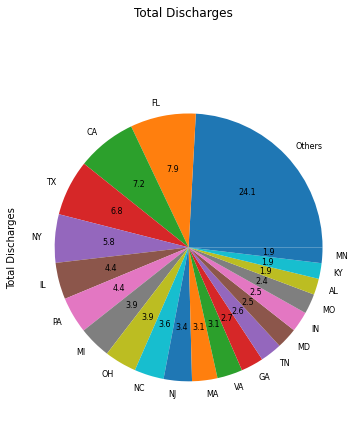

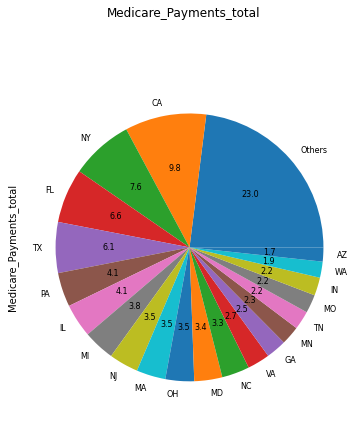

In [17]:
# Making a function to efficiently aggregate & plot data

def grp_plot(grouper,plot_type,topn,*grouped):
    dfts = pd.DataFrame()
    for col in grouped:
        dft=prov.groupby([grouper])[col].sum().sort_values(ascending=False).reset_index().reset_index()
        dft.index.astype('str')
        dfts = dfts.append(100*dft[col]/sum(dft[col]))
        dft.loc[topn:,grouper]='Others'
        dft=dft.groupby([grouper])[col].sum().sort_values(ascending=False)
        if plot_type == 'pie':
            dft.plot(kind=plot_type,subplots=True,title=col,autopct='%.1f',figsize=(6,7),fontsize=8)
            plt.show()
        else: 
            dft.plot(kind=plot_type,subplots=True,title=col,figsize=(6,7),fontsize=8)
            plt.show()

# Plot the aggregated data using the constructed function        
grp_plot('Provider State','pie',20,'Total Discharges','Medicare_Payments_total')

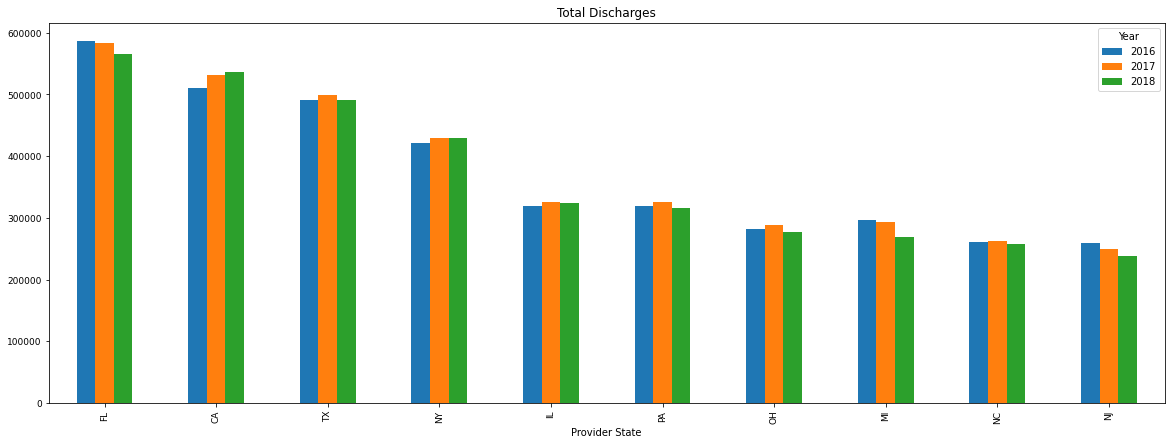

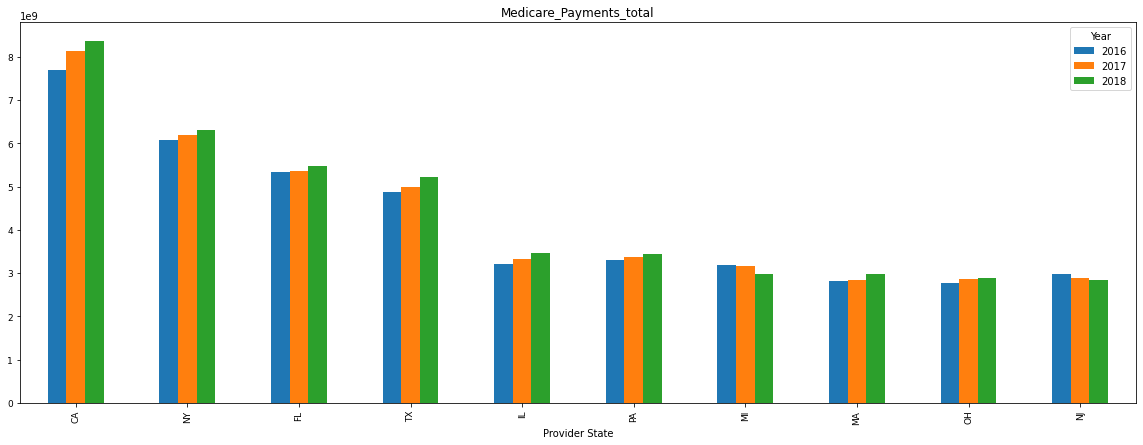

In [18]:
# Analysing Trends in Discharges & Payments over time(2016-2018)

for col in ['Total Discharges','Medicare_Payments_total']:
    prov.groupby(['Provider State','Year'])[col].sum().unstack(level=1).sort_values(by='2018',ascending=False)[:10].stack('Year').unstack(level=1).plot(kind='bar',figsize=(20,7),title=col,fontsize=9)
    #plt.tight_layout()
    plt.show()

In [ ]:
# Introducing Additional Heuristics/Metrics to identify skewed proportions of Medicare allocation across states

temp = prov.groupby(['Provider State']) ['Total Discharges','Medicare_Payments_total'].sum().reset_index()
temp = temp.assign(Total_Discharges_pct = 100*temp['Total Discharges']/sum(temp['Total Discharges']),
                   Medicare_Payments_pct = 100*temp['Medicare_Payments_total']/sum(temp['Medicare_Payments_total']))
temp =  temp.assign(MediPay_Disch_prop = temp['Medicare_Payments_pct']/temp['Total_Discharges_pct'])

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Provider State',y='MediPay_Disch_prop',kind='bar',figsize=(15,3))
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.show()

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Provider State',y='Medicare_Payments_pct',kind='bar',figsize=(15,3))
plt.show()

In [ ]:
#Aggregating Medicare Payments over 'Major Disease families' - Non granular view (top View) by major diseases

grp_plot('Condition_Family','pie',7,'Total Discharges','Medicare_Payments_total')

In [ ]:
# Plotting & Analysing Number of Infected over time for Major Disease families classification

for col in ['Total Discharges','Medicare_Payments_total']:
    prov.groupby(['Condition_Family','Year'])[col].sum().unstack(level=1).sort_values(by='2018',ascending=False)[:5].stack('Year').unstack(level=1).plot(kind='bar',figsize=(20,7),title=col,fontsize=9)
    plt.xticks(rotation=60)
    plt.show()

In [ ]:
# Additional Heuristic/Metric 'MediPay_Disch_prop' for identifying Diseases that occupy a skewed share of total Medicare Payments

temp = prov.groupby(['Condition_Family']) ['Total Discharges','Medicare_Payments_total'].sum().reset_index()
temp = temp[~temp.Condition_Family.isin(['MDC Category Missing'])].assign(Total_Discharges_pct = 100*temp['Total Discharges']/sum(temp['Total Discharges']),
                   Medicare_Payments_pct = 100*temp['Medicare_Payments_total']/sum(temp['Medicare_Payments_total']))
temp =  temp.assign(MediPay_Disch_prop = temp['Medicare_Payments_pct']/temp['Total_Discharges_pct'])

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='MediPay_Disch_prop',kind='bar',figsize=(15,3),fontsize=7)

# Putting a 'Baseline' = 1.0 for identifying diseases that occupy more than average share per discharge of total Medicare Payments
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.xticks(rotation=80)
plt.show()

# Plots for Discharge & Medicare Payments expressed as percentages

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='Medicare_Payments_pct',kind='bar',figsize=(15,3),fontsize=7)
plt.xticks(rotation=80)
plt.show()

temp.sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='Total_Discharges_pct',kind='bar',figsize=(15,3),fontsize=7)
plt.xticks(rotation=80)
plt.show()

# Replotting after removing 'Pre-MDC' which occupies about 10 times Payment per discharge as coompared to the baseline.

temp[temp.Condition_Family!='Pre-MDC'].sort_values(by='MediPay_Disch_prop',ascending=False).plot(x='Condition_Family',y='MediPay_Disch_prop',kind='bar',figsize=(15,3),fontsize=7,title = "MediPay_Disch_prop w/o 'Pre-MDC'")
plt.axhline(y = 1.0, color = 'r', linestyle = '-')
plt.xticks(rotation=80)
plt.show()

In [ ]:
# Analysing 'Pre-MDC' for checking reasons for the hyper-expensiveness of this category

prov.loc[prov.Condition_Family=='Pre-MDC','BASE_COND'].unique()

#Covered expenses fall into the category of 'surgeries' driving the costs very high

In [ ]:
# Plotting & Analysing the Top 10 Health conditions contributing to most Medicare Payments

grp_plot('BASE_COND','pie',10,'Total Discharges','Medicare_Payments_total')

In [1]:
### FLAGGING OVERPAYMENTS at Provider Level (Payments Integrity)

# Establishing National level Baseline for Claims at each DRG Level

prov_avgs_st = prov.groupby(['Provider State','Provider City','MS_DRG_CD'])['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'].sum()
prov_avgs_st = prov_avgs_st.assign(Mean_cov_Ch_st = prov_avgs_st.Covered_Charges_total/prov_avgs_st['Total Discharges'],
                            Mean_Pay_ttl_st = prov_avgs_st.Payments_total/prov_avgs_st['Total Discharges'],
                            Mean_MediPay_ttl_st = prov_avgs_st.Medicare_Payments_total/prov_avgs_st['Total Discharges'])
prov_avgs_st.drop(columns = ['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'],inplace=True)

# Establishing State level Baseline for Claims at each DRG Level

prov_avgs_ntl = prov.groupby(['MS_DRG_CD'])['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'].sum()
prov_avgs_ntl = prov_avgs_ntl.assign(Mean_cov_Ch_ntl = prov_avgs_ntl.Covered_Charges_total/prov_avgs_ntl['Total Discharges'],
                            Mean_Pay_ttl_ntl = prov_avgs_ntl.Payments_total/prov_avgs_ntl['Total Discharges'],
                            Mean_MediPay_ttl_ntl = prov_avgs_ntl.Medicare_Payments_total/prov_avgs_ntl['Total Discharges'])
prov_avgs_ntl.drop(columns = ['Total Discharges','Covered_Charges_total','Payments_total', 'Medicare_Payments_total'],inplace=True)

prov = prov.merge(prov_avgs_st, how='left',on=['Provider State','Provider City','MS_DRG_CD'])
prov = prov.merge(prov_avgs_ntl, how='left',on='MS_DRG_CD')

# Establish Payment Flags where Payment  at Provider level > State, National Levels, also establish multipliers
prov = prov.assign(st_flg_MediPay = prov['Average Medicare Payments'] > prov.Mean_MediPay_ttl_st,
                   ntl_flg_MediPay = prov['Average Medicare Payments'] > prov.Mean_MediPay_ttl_ntl,
                  st_mult_MediPay = prov['Average Medicare Payments']/prov.Mean_MediPay_ttl_st,
                  ntl_mult_MediPay = prov['Average Medicare Payments']/prov.Mean_MediPay_ttl_ntl)

# Print the multipliers for each provider           
prov.groupby(['Provider Id']).agg({'Total Discharges':'sum','st_mult_MediPay':'mean','ntl_mult_MediPay':'mean'}).sort_values(by='st_mult_MediPay',ascending=False)[:10]

# Flag Providers that are consistently overpaid, using multipliers after consultation with Business

NameError: name 'prov' is not defined

In [192]:
### FLAGGING OVERPAYMENTS at Provider Level (Payments Integrity) - Approach2 - ML Algorithm (Local Outlier Factor)

# LOF is a density-based outlier identification method. It flags outliers by analysing local spatial densities.

lof=LocalOutlierFactor()
yhat=lof.fit_predict(prov.set_index('Provider Id')[['Average Total Payments','Average Medicare Payments']])
prov['outlier'] = yhat
outl = 100*prov[prov.outlier==-1].groupby(['Provider Id'])['outlier'].count()/prov.groupby(['Provider Id'])['outlier'].count()
outl.dropna().sort_values(ascending=False)

Provider Id
330405   100.0
110209    55.6
50547     40.0
190313    20.0
340168    20.0
50541     10.5
390272    10.0
220062     9.1
210064     8.0
360365     7.7
50609      6.2
490127     6.2
210058     5.6
10052      4.8
50076      4.5
10150      4.3
670108     3.9
50071      3.7
210027     3.5
50738      3.3
50780      3.3
190116     2.9
210055     2.7
670092     2.6
50772      2.6
210037     2.5
330239     2.4
210056     2.3
440110     2.2
150176     2.2
280134     2.1
150045     2.0
220098     2.0
50013      1.9
210012     1.9
50129      1.9
140040     1.8
150076     1.8
100107     1.8
140013     1.7
100285     1.7
670096     1.7
50588      1.7
250057     1.6
30137      1.5
670031     1.4
100054     1.4
390228     1.4
150175     1.4
50058      1.4
190050     1.3
440193     1.2
390032     1.2
140125     1.2
520075     1.2
100302     1.2
190263     1.2
390037     1.1
10001      1.1
100028     1.1
110089     1.1
50272      1.0
10108      1.0
420089     1.0
420010     1.0
280128     1.

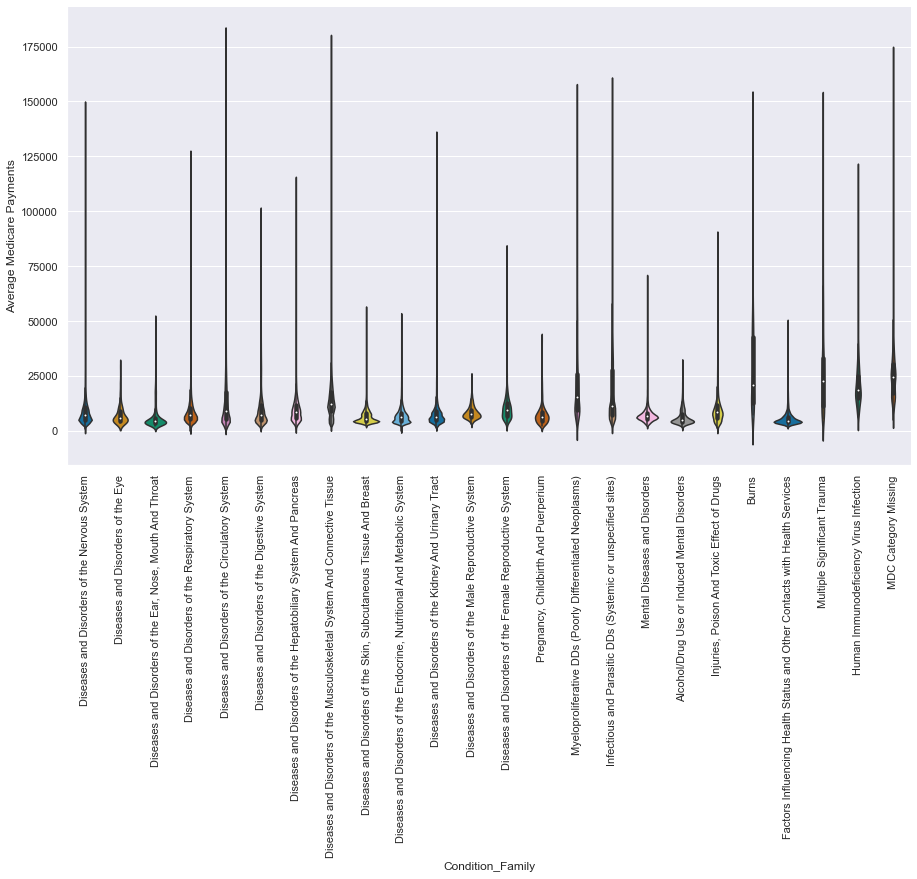

In [193]:
# Additional Plot 1 - Medicare Payments by Major Disease families

sns.set(style="darkgrid")
sns.catplot(data=prov[~prov.Condition_Family.isin(['Pre-MDC','Diseases and Disorders of the Blood and Blood Forming Organs and Immunological Disorders'])],x='Condition_Family',y='Average Medicare Payments',palette="colorblind",kind='violin',height = 7,aspect = 2,fontsize=8)
plt.xticks(rotation=90)
plt.show()

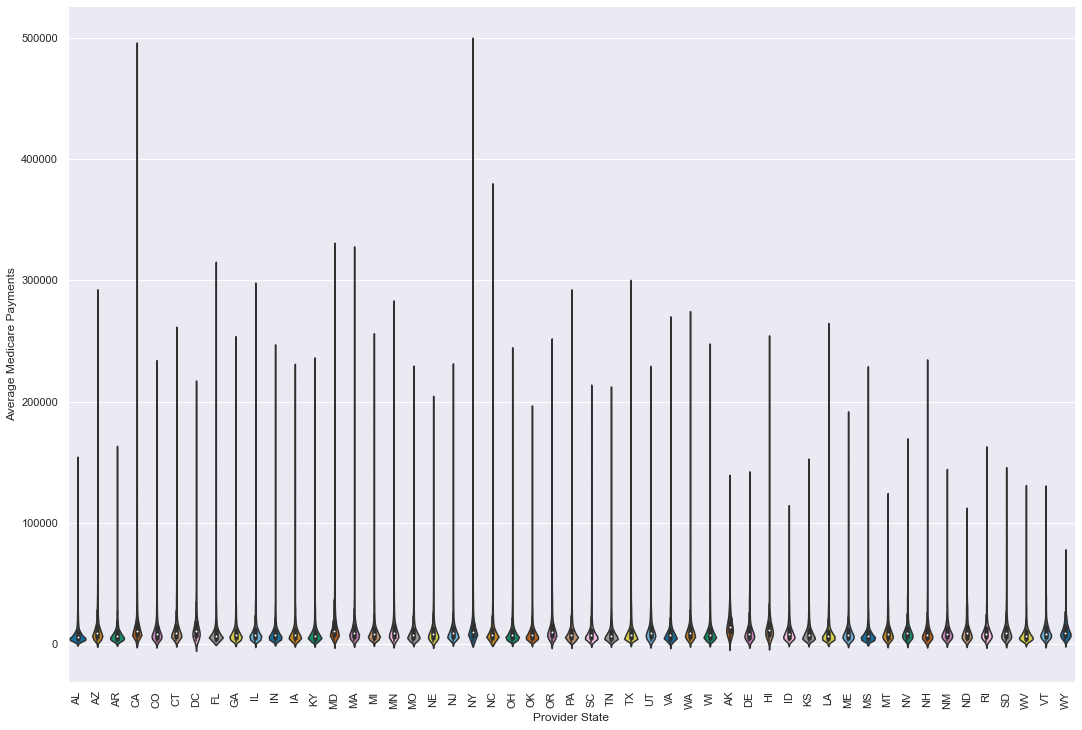

In [194]:
# Additional Plot 2 - Medicare Payments by States
sns.catplot(data=prov,x='Provider State',y='Average Medicare Payments',palette="colorblind",kind='violin',height = 10,aspect =1.5)
plt.xticks(rotation=90)
plt.show()

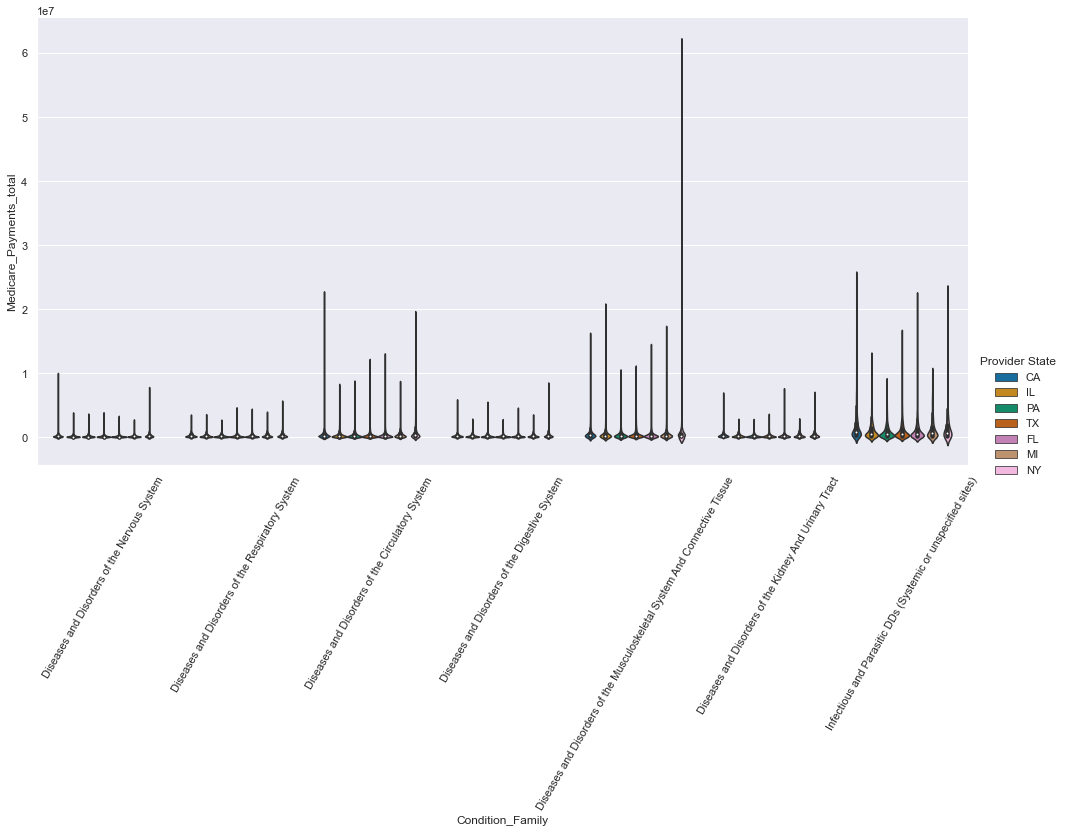

In [196]:
# Additional Plot 3 - Medicare Payments across Top 7 states for Top 7 Diseases

top7con = prov.groupby(['Condition_Family'])['Medicare_Payments_total'].sum().sort_values(ascending=False).reset_index().iloc[:7,0].tolist()
top7st = prov.groupby(['Provider State'])['Medicare_Payments_total'].sum().sort_values(ascending=False).reset_index().iloc[:7,0].tolist()

top7dfint = prov[prov.Condition_Family.isin(top7con)]
top7df = top7dfint[top7dfint['Provider State'].isin(top7st)]

sns.factorplot(x="Condition_Family", y="Medicare_Payments_total",data=top7df,palette="colorblind",kind='violin',size = 7,aspect = 2,hue='Provider State')
plt.xticks(rotation=60)
plt.show()

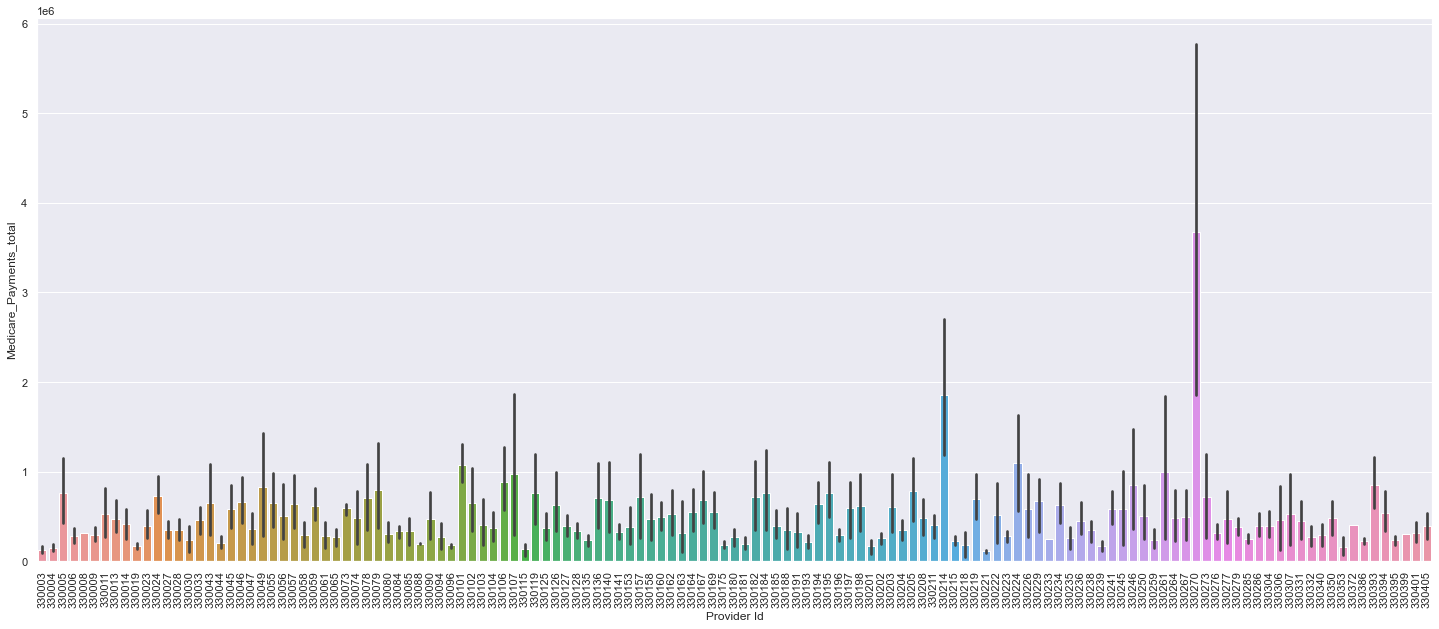

In [197]:
# Digging into skewed "NY - Disease & Disorders of Musculoskeletal System......." flagged in above plot

ny = top7df[(top7df['Provider State']=='NY') & (top7df.Condition_Family=='Diseases and Disorders of the Musculoskeletal System And Connective Tissue')]
plt.figure(figsize=(25,10))
sns.barplot(y=ny['Medicare_Payments_total'],x= ny['Provider Id'])
plt.xticks(rotation=90)
plt.show()

# Flagging outliers Providers in NY state derived from above aggregation

### Data Preparation & EDA - Inpatients Data

In [198]:
# Merge Additional info from CMS.gov & Wikipedia to Inpatients data

inpcl = inpcl.merge(table,how='left',on='IP_CLM_BASE_DRG_CD')
inpcl = pd.merge(inpcl,DRG_Class, how='left',on='MS_DRG_CD')

# Checking for Nan values
inpcl.isna().sum()

IP_CLM_ID                    0
BENE_SEX_IDENT_CD            0
BENE_AGE_CAT_CD              0
IP_CLM_BASE_DRG_CD           0
IP_CLM_ICD9_PRCDR_CD    633642
IP_CLM_DAYS_CD               0
IP_DRG_QUINT_PMT_AVG         0
IP_DRG_QUINT_PMT_CD          0
MS_DRG_CD                    0
BASE_COND                    0
MDC                       7783
Condition_Family             0
dtype: int64

In [239]:
inpcl.describe(include='all')

,IP_CLM_ID,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,IP_CLM_BASE_DRG_CD,IP_CLM_ICD9_PRCDR_CD,IP_CLM_DAYS_CD,IP_DRG_QUINT_PMT_AVG,IP_DRG_QUINT_PMT_CD,MS_DRG_CD,BASE_COND,MDC,Condition_Family,outlier
count,1400216,"1,400,216.0","1,400,216.0","1,400,216.0","766,574.0","1,400,216.0","1,400,216.0","1,400,216.0","1,400,216.0",1400216,"1,392,433.0",1400216,"1,400,216.0"
unique,588415,nan,nan,nan,nan,nan,nan,nan,nan,311,25.0,26,nan
top,IP-BA8389D6F3A56CA1,nan,nan,nan,nan,nan,nan,nan,nan,Heart failure & shock,5.0,Diseases and Disorders of the Circulatory System,nan
freq,3,nan,nan,nan,nan,nan,nan,nan,nan,88122,"340,655.0",340655,nan
mean,NaN,1.6,3.6,133.2,58.8,2.5,"9,215.1",3.0,415.1,NaN,nan,NaN,0.9
std,NaN,0.5,1.8,75.4,28.5,1.0,"9,267.6",1.4,246.0,NaN,nan,NaN,0.5
min,NaN,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,nan,NaN,-1.0
25%,NaN,1.0,2.0,77.0,38.0,2.0,"4,353.0",2.0,228.0,NaN,nan,NaN,1.0
50%,NaN,2.0,4.0,110.0,51.0,2.0,"6,574.0",3.0,331.0,NaN,nan,NaN,1.0
75%,NaN,2.0,5.0,190.0,86.0,3.0,"10,708.0",4.0,602.0,NaN,nan,NaN,1.0


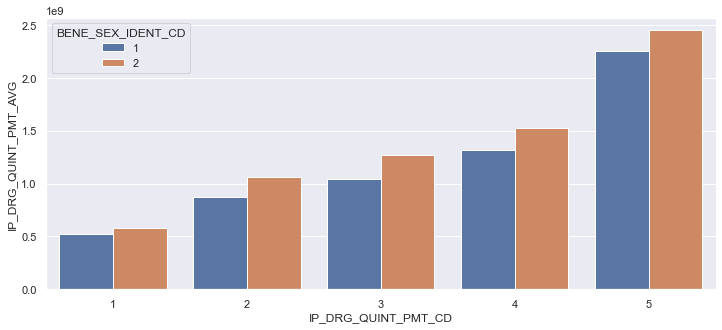

In [199]:
# Plotting Genderwise differences across the 5 quintiles of Payments basis 'IP_DRG_QUINT_PMT_CD' field
fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['IP_DRG_QUINT_PMT_CD','BENE_SEX_IDENT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'IP_DRG_QUINT_PMT_CD',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.show()

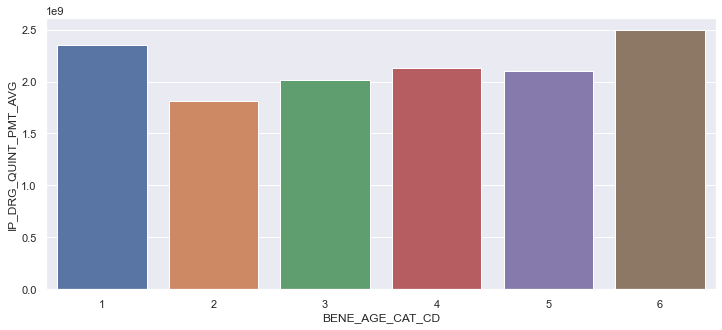

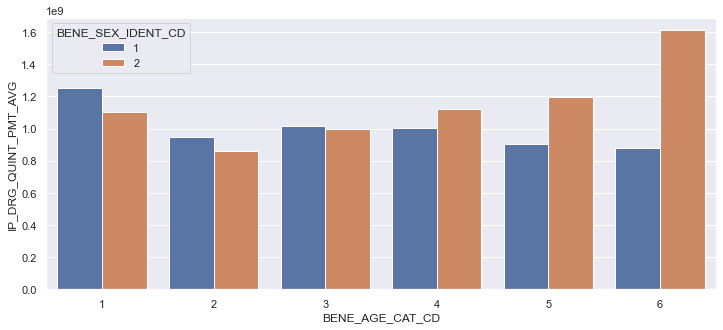

In [200]:
# Plotting Genderwise Avg Claim differences across Quintiles basis 'IP_DRG_QUINT_PMT_CD' field  

fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['BENE_AGE_CAT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'BENE_AGE_CAT_CD',y='IP_DRG_QUINT_PMT_AVG')
plt.show()

# Plotting Avg Claim differences across the 5 age categories, subdivided by gender

fig = plt.gcf()
fig.set_size_inches(12,5)
sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index(), x= 'BENE_AGE_CAT_CD',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.show()

# Avg Claim amounts for Females > Males for younger-age categories whereas Avg Claims for males > females for older age categories 


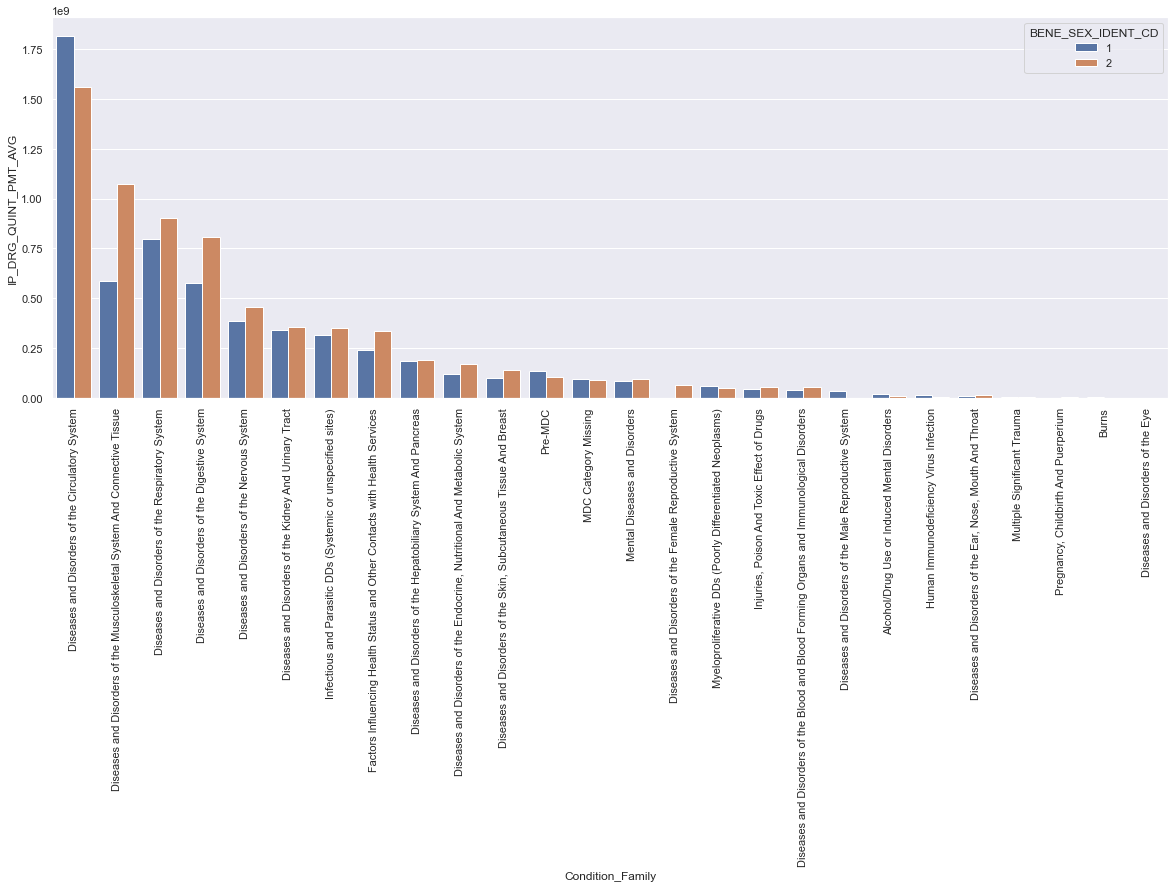

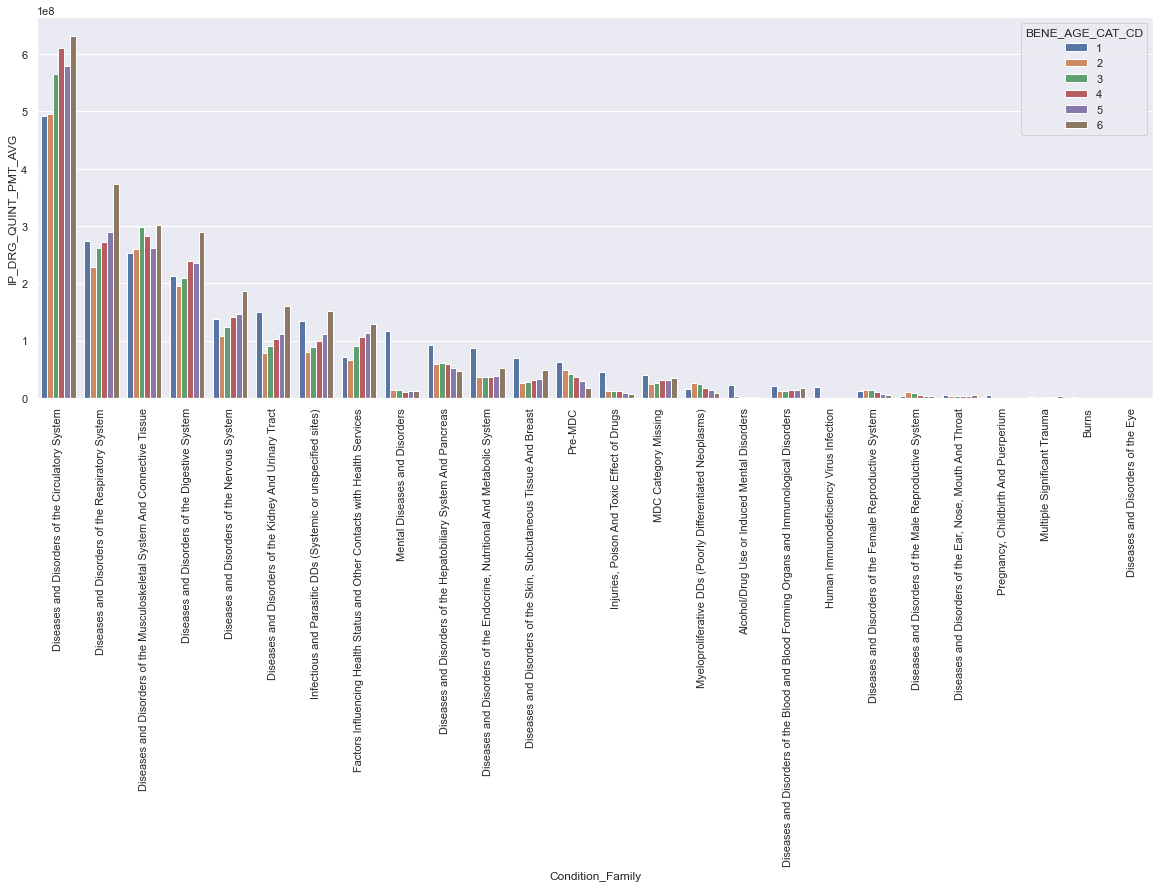

In [202]:
# Plotting Claim Amount differences across Major disease, subdivided by Gender

fig = plt.gcf()
fig.set_size_inches(20,7)
sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD','Condition_Family'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index().sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False), x= 'Condition_Family',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_SEX_IDENT_CD')
plt.xticks(rotation=90)
plt.show()

# Plotting Claim Amount differences across Major disease, subdivided by Age Categories

fig = plt.gcf()
fig.set_size_inches(20,7)
sns.barplot(data=inpcl.groupby(['BENE_AGE_CAT_CD','Condition_Family'])['IP_DRG_QUINT_PMT_AVG'].sum().reset_index().sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False), x= 'Condition_Family',y='IP_DRG_QUINT_PMT_AVG',hue='BENE_AGE_CAT_CD')
plt.xticks(rotation=90)
plt.show()

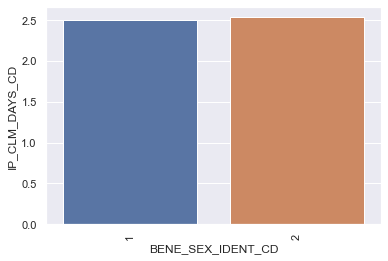

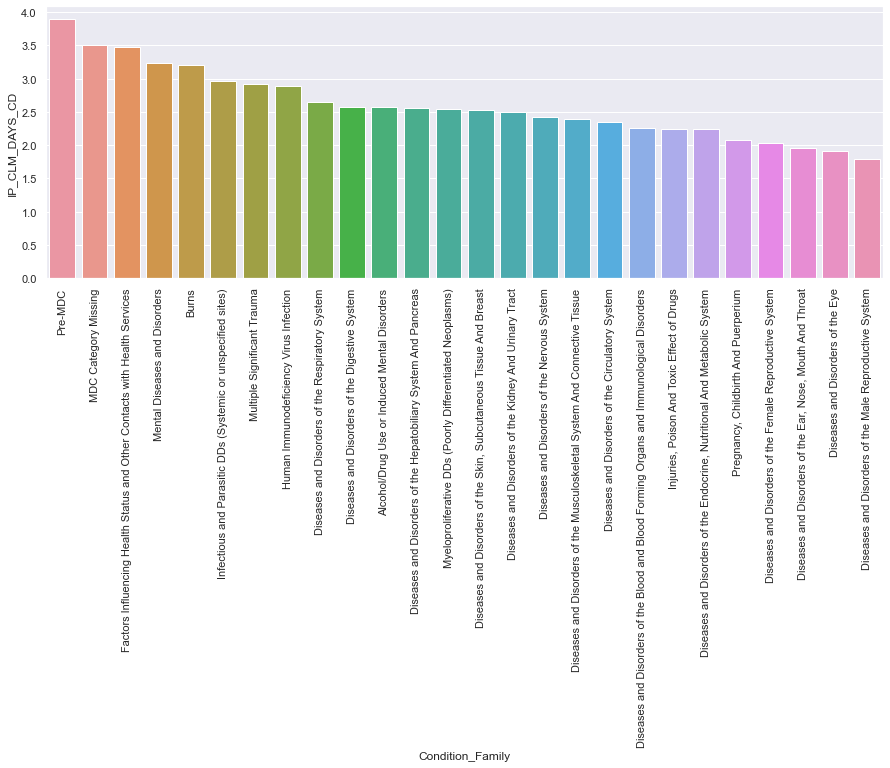

In [203]:
#Average hospital stay across Genders

sns.barplot(data=inpcl.groupby(['BENE_SEX_IDENT_CD'])['IP_CLM_DAYS_CD'].mean().reset_index().sort_values(by='IP_CLM_DAYS_CD',ascending=False), x= 'BENE_SEX_IDENT_CD',y='IP_CLM_DAYS_CD')
plt.xticks(rotation=90)
plt.show()

#Average hospital stay across different Age Categories

fig = plt.gcf()
fig.set_size_inches(15,5)
sns.barplot(data=inpcl.groupby(['Condition_Family'])['IP_CLM_DAYS_CD'].mean().reset_index().sort_values(by='IP_CLM_DAYS_CD',ascending=False), x= 'Condition_Family',y='IP_CLM_DAYS_CD')
plt.xticks(rotation=90)
plt.show()

In [232]:
### FLAGGING OUTLIER CLAIMS - Approach 1 - using Category Averages

test = inpcl[['IP_CLM_ID','BASE_COND','BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']]

# Flagging Top 0.1% & Bottom 0.1% Claims across each 'Gender-Age-DRG' Combination as Outliers

outliers = pd.DataFrame()
for cond in test[['IP_CLM_ID','BASE_COND','BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']].BASE_COND.unique():
    df = test[test.BASE_COND==cond]
    df = df[['IP_CLM_ID','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG']].set_index('IP_CLM_ID')
    for cat in df.BENE_AGE_CAT_CD:
        dff = df[df.BENE_AGE_CAT_CD==cat]
        df_low = dff['IP_DRG_QUINT_PMT_AVG'].quantile(0.001)
        df_hi  = dff['IP_DRG_QUINT_PMT_AVG'].quantile(0.999)
    
        outliers = outliers.append(df[(df['IP_DRG_QUINT_PMT_AVG'] > df_hi)])
        outliers.append(df[(df["Medicare_Payments_total"] < df_low)])
    
outliers

,BENE_AGE_CAT_CD,IP_DRG_QUINT_PMT_AVG
IP_CLM_ID,,
IP-000D31A70A92CF79,6,10001
IP-000D31A70A92CF79,6,10001
IP-000D31A70A92CF79,6,10001
IP-00D3FDD00C91880B,5,10001
IP-00D3FDD00C91880B,5,10001
IP-00D3FDD00C91880B,5,10001
IP-01B04A24598ED658,1,10001
IP-01B04A24598ED658,1,10001
IP-01B04A24598ED658,1,10001


In [231]:
### Flagging Outlier claims - Machine Learning Approach (Local Outlier Factor Algorithm)

# LOF is a density-based outlier identification method. It flags outliers by analysing local spatial densities.

lof=LocalOutlierFactor()
yhat=lof.fit_predict(inpcl.set_index('IP_CLM_ID')[['BENE_SEX_IDENT_CD','BENE_AGE_CAT_CD','IP_DRG_QUINT_PMT_AVG','IP_CLM_DAYS_CD']])
inpcl['outlier'] = yhat
inpcl.loc[inpcl.outlier==-1].sort_values(by='IP_DRG_QUINT_PMT_AVG',ascending=False)

,IP_CLM_ID,BENE_SEX_IDENT_CD,BENE_AGE_CAT_CD,IP_CLM_BASE_DRG_CD,IP_CLM_ICD9_PRCDR_CD,IP_CLM_DAYS_CD,IP_DRG_QUINT_PMT_AVG,IP_DRG_QUINT_PMT_CD,MS_DRG_CD,BASE_COND,MDC,Condition_Family,outlier
1202041,IP-DB9DBD5D3347CB7C,1,1,294,86.0,4,226550,5,927,Extensive burns or full thickness burns w MV\r96+ hrs w skin graft,22.0,Burns,-1
962950,IP-B0196C9760EE4171,1,1,294,86.0,4,226550,5,927,Extensive burns or full thickness burns w MV\r96+ hrs w skin graft,22.0,Burns,-1
1114816,IP-CBC958F3249DE04B,1,2,2,45.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
306522,IP-383476FDDCD89CAE,2,1,2,86.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
260246,IP-2FB50776371E910D,2,1,2,39.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
411687,IP-4B3872DD43E8FD01,2,1,2,50.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
1110430,IP-CAFB188CDA4D38E9,1,2,2,81.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
1254532,IP-E5459100C94C9EA8,1,2,2,34.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
1112206,IP-CB4D6C19FBC715D7,1,2,2,36.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
1336284,IP-F43225B091E405DE,1,2,2,31.0,4,222276,5,3,"ECMO or trach w MV 96+ hrs or PDX exc face, mouth & neck w maj O.R.",0.0,Pre-MDC,-1
